<a href="https://colab.research.google.com/github/deveshusg/credit-risk-portfolio/blob/main/notebooks/01_through_the_cycle_pd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01_through_the_cycle_pd.ipynb

**Project:** Through-the-Cycle (TTC) PD — `Give Me Some Credit` demo (education / reproducible example)

**Purpose & structure**
- Demonstrate a full TTC-style PD analysis pipeline on a small public dataset for portfolio learning and interview-defendable reproducibility.
- Notebook flow (each section explains *what*, *why*, and *alternatives*):
  1. Setup & data load (robust path handling)
  2. Exhaustive EDA (univariate, missingness, correlations, target stratification)
  3. Data prep & feature engineering (imputation, encoding, scaling, cyclical-adjustment notes)
  4. Model training (pipeline + logistic regression for interpretability)
  5. Evaluation & validation (AUC, KS, calibration, PSI placeholder)
  6. Next steps / governance notes

> This notebook is intentionally reproducible: minimal outputs embedded and strict preprocessing to avoid NaNs in models. Save to `notebooks/01_through_the_cycle_pd.ipynb` and run in Colab or locally.

## 1) Setup & imports

Install dependencies if running in a fresh Colab environment. Then import libraries. This cell does not assume heavy packages beyond `pandas` and `sklearn` which are standard.

In [47]:
# If running in Colab uncomment these installs (only if missing)
# !pip install -q scikit-learn pandas matplotlib seaborn imbalanced-learn

import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report

print('Python version:', sys.version.splitlines()[0])
print('pandas:', pd.__version__)


Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
pandas: 2.2.2


### Data path and robust loading
- Primary path: `data/raw/GiveMeSomeCredit/cs-training.csv` (as you said). If not found, the cell will try `data/GiveMeSomeCredit/cs-training.csv` and `data/sample_pit.csv` as fallback (so Colab / binder runs won't fail).

In [48]:
# Data path (edit if your file is elsewhere)
candidates = [
    'data/raw/GiveMeSomeCredit/cs-training.csv',
    'data/GiveMeSomeCredit/cs-training.csv',
    'data/sample_pit.csv'
]

DATA_PATH = None
for p in candidates:
    if Path(p).exists():
        DATA_PATH = p
        break

if DATA_PATH is None:
    raise FileNotFoundError(
        'Could not find dataset. Put GiveMeSomeCredit cs-training.csv at one of: ' + ', '.join(candidates)
    )

print('Using data file:', DATA_PATH)

# Load dataset with appropriate options
df = pd.read_csv(DATA_PATH)
print('Raw shape:', df.shape)
df.head()


Using data file: data/raw/GiveMeSomeCredit/cs-training.csv
Raw shape: (150000, 12)


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


## 2) Exhaustive EDA

Goal: produce a complete picture of feature distributions, missingness, correlation, and target behavior.
We'll examine:
- Basic shape and dtypes
- Missing value table
- Target balance and stratified distributions
- Univariate statistics for numeric variables
- Correlation matrix and multicollinearity diagnostics
- Quick checks for outliers / ranges

Comments: For TTC work, focus on features that reflect *borrower fundamentals* rather than purely cyclical indicators. In small demos we still follow same steps.

Columns and dtypes:


,0
Unnamed: 0,int64
SeriousDlqin2yrs,int64
RevolvingUtilizationOfUnsecuredLines,float64
age,int64
NumberOfTime30-59DaysPastDueNotWorse,int64
DebtRatio,float64
MonthlyIncome,float64
NumberOfOpenCreditLinesAndLoans,int64
NumberOfTimes90DaysLate,int64
NumberRealEstateLoansOrLines,int64



Describe (numeric):


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,150000.0,75000.500000,43301.414527,1.0,37500.750000,75000.500000,112500.250000,150000.0
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0



Missing value counts:


,0
MonthlyIncome,29731
NumberOfDependents,3924



Target column chosen as: SeriousDlqin2yrs

Target value counts:


,count
SeriousDlqin2yrs,
0,139974
1,10026


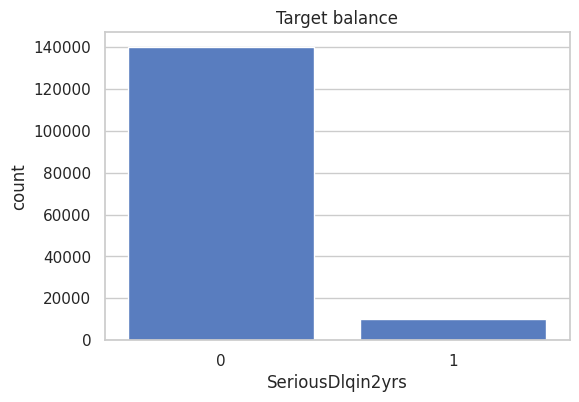

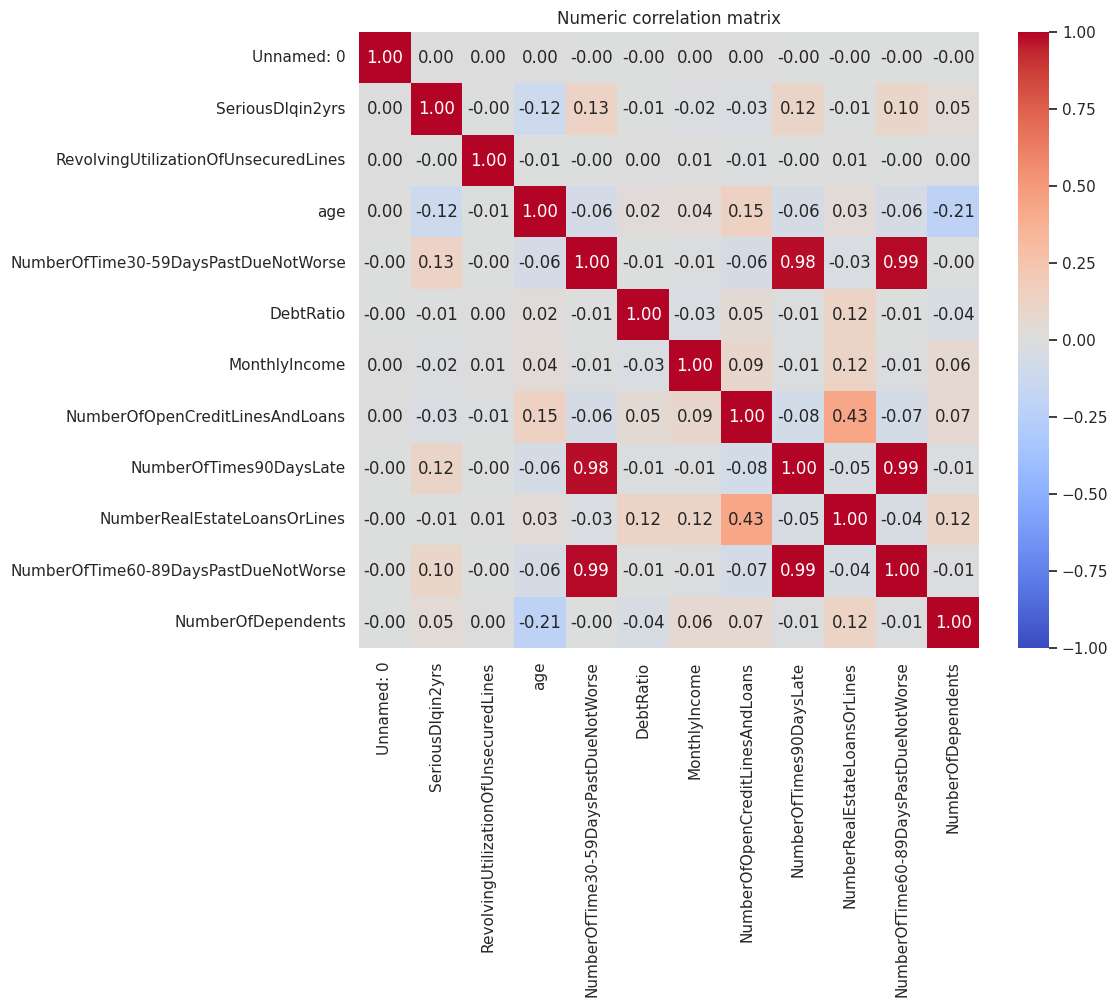

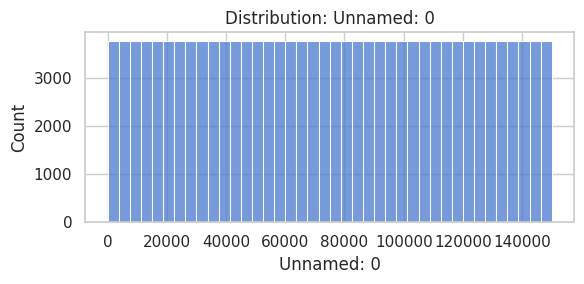

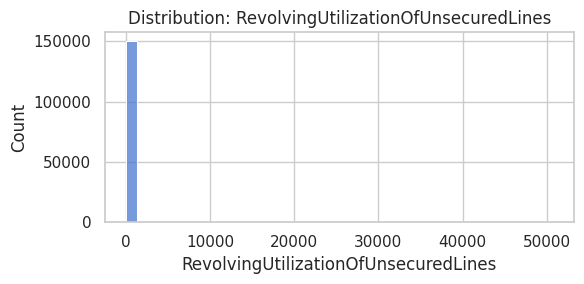

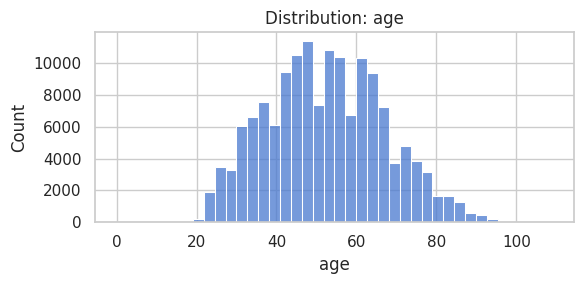

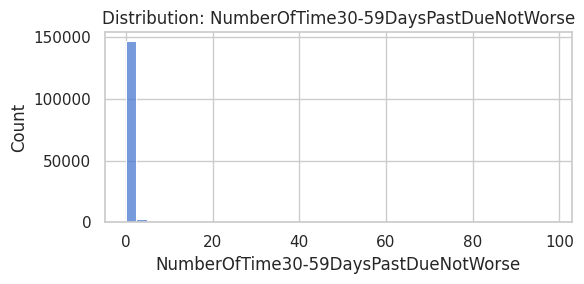

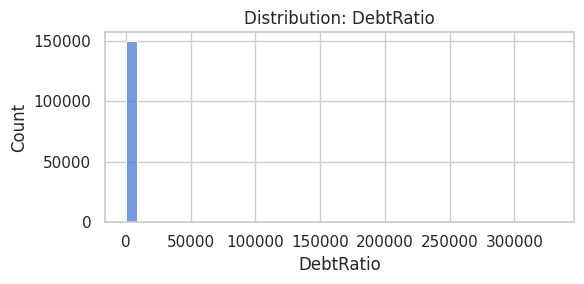

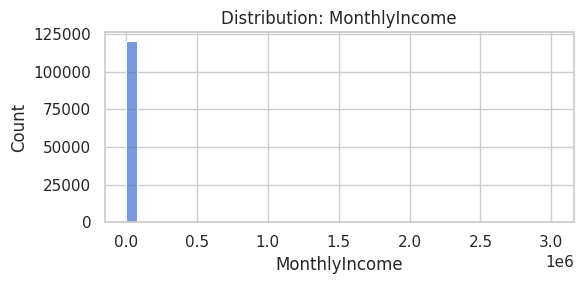

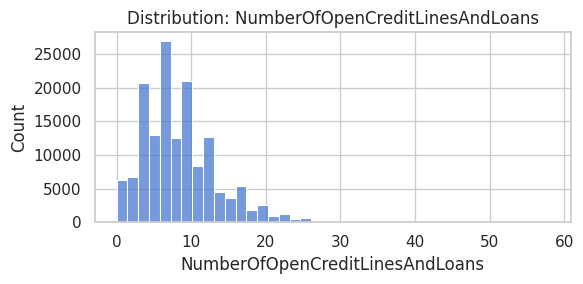

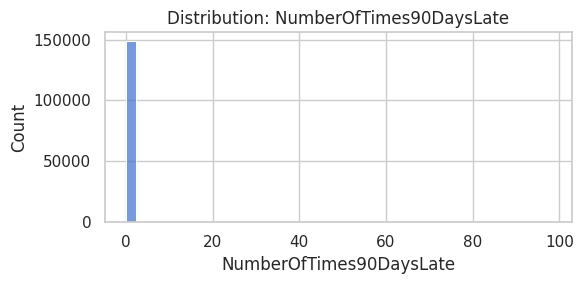

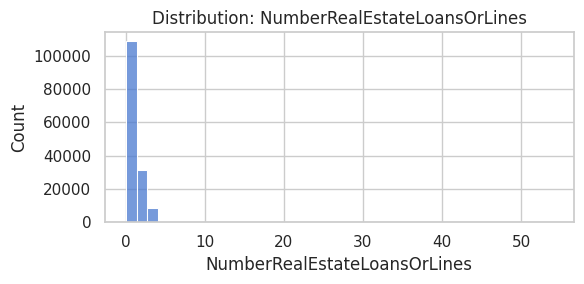

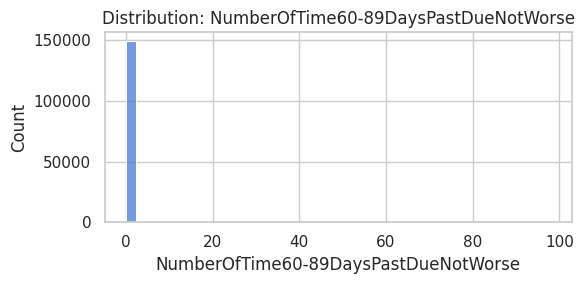

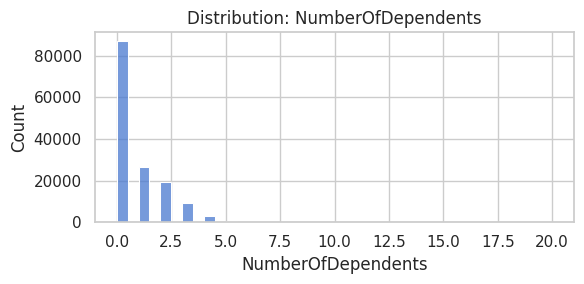

In [49]:
# Basic info
print('Columns and dtypes:')
display(df.dtypes)

print('\nDescribe (numeric):')
display(df.describe().T)

# Missingness summary
missing = df.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]
if len(missing)==0:
    print('\nNo missing values detected in raw file')
else:
    print('\nMissing value counts:')
    display(missing)

# Target distribution - the GiveMeSomeCredit dataset uses 'SeriousDlqin2yrs' as target
TARGET = 'SeriousDlqin2yrs' if 'SeriousDlqin2yrs' in df.columns else df.columns[-1]
print('\nTarget column chosen as:', TARGET)
print('\nTarget value counts:')
display(df[TARGET].value_counts(dropna=False))

# Plot target balance
plt.figure(figsize=(6,4))
sns.countplot(x=TARGET, data=df)
plt.title('Target balance')
plt.show()

# Correlation heatmap (numeric only)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) > 1:
    plt.figure(figsize=(10,8))
    sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Numeric correlation matrix')
    plt.show()

# Quick univariate distributions for numeric features
for c in num_cols:
    if c == TARGET:
        continue
    plt.figure(figsize=(6,3))
    sns.histplot(df[c].dropna(), kde=False, bins=40)
    plt.title(f'Distribution: {c}')
    plt.tight_layout()
    plt.show()


## 3) Data Preparation & Feature Engineering

Plan (keeps TTC focus):
- Minimal, defensible feature set derived from the dataset (no heavy cyclical signals here).
- Impute missing numeric values with median (robust) and categorical with mode.
- Scale numeric features for logistic regression.
- Use a `ColumnTransformer` + `Pipeline` so preprocessing is encapsulated and reproducible.

Alternative choices:
- Use model-based imputation (IterativeImputer) for more accuracy.
- If building true TTC, regress features on macro index and keep residuals; here we place a placeholder for that step.

In [50]:
# Identify feature columns (simple heuristic)
all_cols = df.columns.tolist()
if TARGET in all_cols:
    feature_cols = [c for c in all_cols if c != TARGET]
else:
    # fallback - assume last column is target
    feature_cols = all_cols[:-1]

# split numeric and categorical
numeric_features = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in feature_cols if c not in numeric_features]

print('Numeric features:', numeric_features)
print('Categorical features:', categorical_features)

# Build preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'  # drop any other columns
)

# Create full pipeline with model
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000, solver='lbfgs'))
])

# Train-test split stratified by target
X = df[feature_cols]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)


Numeric features: ['Unnamed: 0', 'RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']
Categorical features: []
Train shape: (120000, 11) Test shape: (30000, 11)


### 3.1 Sanity checks before fitting
- We'll fit the pipeline directly which handles imputation; but we also perform an explicit transform to assert *no missing values remain* after preprocessing.
- This prevents the earlier `ValueError: Input X contains NaN` which occurs when models get NaNs.


In [51]:
# Fit only the preprocessor to training data and transform both train & test
preprocessor.fit(X_train)
X_train_t = preprocessor.transform(X_train)
X_test_t = preprocessor.transform(X_test)

# After transform, ensure no NaNs remain
nans_train = np.isnan(X_train_t).sum()
nans_test = np.isnan(X_test_t).sum()
print('NaNs after preprocessing (train):', int(nans_train))
print('NaNs after preprocessing (test):', int(nans_test))

if nans_train != 0 or nans_test != 0:
    # helpful debug: show columns with missing values before transform
    print('\nColumns with missing values before preprocessing (train):')
    print(X_train.isnull().sum()[X_train.isnull().sum() > 0])
    raise AssertionError('⚠️ Missing values remain after preprocessing! Check imputer configuration.')
else:
    print('\n✅ No missing values remain after preprocessing. Ready to fit model.')


NaNs after preprocessing (train): 0
NaNs after preprocessing (test): 0

✅ No missing values remain after preprocessing. Ready to fit model.


## 4) Model training

Train the logistic regression within the pipeline. We keep logistic for interpretability; alternatives may include tree-based models (LightGBM) which can handle missing values natively and often produce better raw performance.
We also show simple cross-validated AUC.

ROC AUC (test): 0.7144

Classification report (test):
              precision    recall  f1-score   support

           0     0.9359    0.9977    0.9658     27995
           1     0.5833    0.0454    0.0842      2005

    accuracy                         0.9340     30000
   macro avg     0.7596    0.5215    0.5250     30000
weighted avg     0.9123    0.9340    0.9069     30000



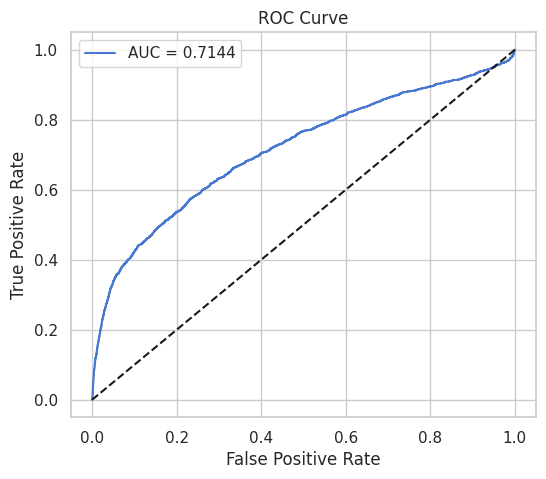

In [52]:
# Fit full pipeline on training data
clf.fit(X_train, y_train)

# Predict & evaluate
y_pred_proba = clf.predict_proba(X_test)[:, 1]
y_pred = clf.predict(X_test)

auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC AUC (test): {auc:.4f}')

print('\nClassification report (test):')
print(classification_report(y_test, y_pred, digits=4))

# ROC curve plot
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


## 5) Simple calibration & stability checks

This section provides quick sanity checks: calibration by deciles, and a placeholder for Population Stability Index (PSI) between train & test or across vintages. For formal governance, you'd perform backtests by vintage and long-run calibration to TTC-levels.

In [53]:
# Calibration by decile
df_eval = pd.DataFrame({'y_true': y_test, 'y_proba': y_pred_proba})
df_eval['decile'] = pd.qcut(df_eval['y_proba'].rank(method='first'), 10, labels=False)
cal = df_eval.groupby('decile').agg(n=('y_true','size'),
                                     actual_default_rate=('y_true','mean'),
                                     avg_pred_proba=('y_proba','mean')).reset_index()
display(cal)

# Quick PSI placeholder function (train vs test distributions for score)
def psi(expected, actual, buckets=10):
    # expected/actual are 1d arrays
    exp_perc, bins = np.histogram(expected, bins=buckets, density=True)
    act_perc, _ = np.histogram(actual, bins=bins, density=True)
    # avoid zeros
    exp_perc = np.where(exp_perc==0, 1e-6, exp_perc)
    act_perc = np.where(act_perc==0, 1e-6, act_perc)
    return np.sum((exp_perc - act_perc) * np.log(exp_perc / act_perc))

train_scores = clf.predict_proba(X_train)[:,1]
test_scores = y_pred_proba
psi_val = psi(train_scores, test_scores, buckets=10)
print(f'PSI (train vs test): {psi_val:.6f}  (small -> stable; >0.25 suggests shift)')


,decile,n,actual_default_rate,avg_pred_proba
0,0,3000,0.048667,0.021008
1,1,3000,0.023000,0.029901
2,2,3000,0.023000,0.035760
3,3,3000,0.033333,0.041831
4,4,3000,0.036000,0.049154
5,5,3000,0.044333,0.057552
6,6,3000,0.051667,0.067210
7,7,3000,0.064667,0.078758
8,8,3000,0.082000,0.094711
9,9,3000,0.261667,0.194472


PSI (train vs test): 0.005596  (small -> stable; >0.25 suggests shift)


## 6) Save artefacts and next steps

- Save the trained pipeline for reproducibility and deployment.
- Document assumptions: imputation strategy, variable selection, and the fact this is an educational TTC-style workflow on a small dataset.
- Next steps for true TTC: obtain macro series, model feature → macro regression to remove cyclical component (keep residuals), re-estimate long-run PD calibration using multi-year vintages.

In [54]:
# Save pipeline artifact
import joblib
ARTIFACTS_DIR = Path('artifacts')
ARTIFACTS_DIR.mkdir(exist_ok=True)
joblib.dump(clf, ARTIFACTS_DIR / 'ttc_pit_pipeline_lgr.joblib')
print('Saved pipeline to', ARTIFACTS_DIR / 'ttc_pit_pipeline_lgr.joblib')

# Final message
print('\nDone. Notebook ran end-to-end with imputation & pipeline to avoid NaN issues in modeling.')


Saved pipeline to artifacts/ttc_pit_pipeline_lgr.joblib

Done. Notebook ran end-to-end with imputation & pipeline to avoid NaN issues in modeling.


### Suggestions to improve this notebook
1. Replace simple median imputation with `IterativeImputer` or model-based imputation for better fidelity.
2. Use cross-validation with time-based folds if you have time-series/vintage structure.
3. For TTC adjustment: collect macro series (GDP, unemployment), build a credit-cycle index, regress features on the cycle and keep residuals for TTC model training.
4. Add model explainability: coefficient table for logistic regression, SHAP for tree models.
5. Implement model validation docs (MDD) and automated unit tests for data pipelines.